In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import statsmodels.api as sm

sns.set_style("whitegrid")

/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [13]:
def bma(X, y=None):
    N, p = X.shape

    with pm.Model() as model:
        X_tt = pm.Data('X_tt', X)
        y_tt = pm.Data('y_tt', y if y is not None else np.zeros(N))

        z = pm.Bernoulli('z', p=0.5, shape=(p, ))
        τ = pm.Gamma('τ', alpha=2/2, beta=(2*1)/2)
        g_prior_cov = 1/τ * N * np.linalg.inv(X.T@X)
        β = pm.MvNormal('β', mu=np.zeros(p), cov=g_prior_cov, shape=(p, ))
        zβ = pm.Deterministic('zβ', pm.math.prod([z, β], axis=0))

        likelihood = pm.Normal('y', mu=pm.math.dot(X_tt, zβ), tau=τ, observed=y_tt)
    
    return model

def bayes_ols(X, y=None):
    N, p = X.shape

    with pm.Model() as model:
        X_tt = pm.Data('X_tt', X)
        y_tt = pm.Data('y_tt', y if y is not None else np.zeros(N))

        τ = pm.Gamma('τ', alpha=2/2, beta=(2*1)/2)
        g_prior_cov = 1/τ * N * np.linalg.inv(X.T@X)
        β = pm.MvNormal('β', mu=np.zeros(p), cov=g_prior_cov, shape=(p, ))

        likelihood = pm.Normal('y', mu=pm.math.dot(X_tt, β), tau=τ, observed=y_tt)
    
    return model

In [5]:
df = pd.read_csv('crime.dat', delim_whitespace=' ')

### All Data

In [54]:
X = sm.add_constant(df.loc[:, [c for c in df.columns if c != 'y']])
y = df.y

/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [56]:
bols = bayes_ols(X, y)

seed = 602
with bols:
    post_ss = pm.sample(2000, tune=1000, chains=4, random_seed=seed, return_inferencedata=True)
    pp = pm.sample_posterior_predictive(post_ss, samples=4*2000, var_names=['β', 'τ'], random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, τ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [62]:
np.round(pd.DataFrame(pp['β']).mean(0).values, 2)

array([-0.  ,  0.28,  0.  ,  0.54,  1.45, -0.77, -0.06,  0.13, -0.07,
        0.11, -0.27,  0.36,  0.24,  0.71, -0.28, -0.06])

In [63]:
np.round(pd.DataFrame(pp['β']).quantile([0.025, 0.975]), 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.025,-0.14,0.04,-0.33,0.21,-0.05,-2.34,-0.34,-0.15,-0.29,-0.20,-0.61,0.03,-0.23,0.29,-0.52,-0.30
0.975,0.14,0.52,0.33,0.86,2.91,0.81,0.20,0.40,0.16,0.42,0.09,0.69,0.70,1.13,-0.04,0.18


<AxesSubplot:>

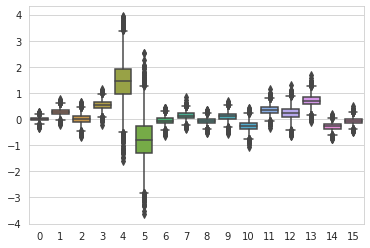

In [64]:
sns.boxplot(pd.DataFrame(pp['β']))

In [65]:
ols = sm.OLS(y, X).fit()

In [66]:
np.round(ols.params.values, 2)

array([-0.  ,  0.29, -0.  ,  0.54,  1.47, -0.78, -0.07,  0.13, -0.07,
        0.11, -0.27,  0.37,  0.24,  0.73, -0.29, -0.06])

### Train Test Comp

In [84]:
from sklearn.model_selection import train_test_split

seed = 602
np.random.seed(seed)

X = sm.add_constant(df.loc[:, [c for c in df.columns if c != 'y']])
X_train, X_test = train_test_split(X, test_size=0.5)
y_train, y_test = df.loc[X_train.index, 'y'], df.loc[X_test.index, 'y']

/home/ztang484/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [93]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression(fit_intercept=False)
ols.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [104]:
bols = bayes_ols(X_train, y_train)

with bols:
    post_ss = pm.sample(2000, tune=1000, chains=1, random_seed=seed, return_inferencedata=True)

bols = bayes_ols(X_test, None)
with bols:
    pp = pm.sample_posterior_predictive(post_ss, samples=2000, var_names=['β', 'τ', 'y'], random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [β, τ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 50 seconds.
There were 795 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6522659221606412, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


3.1352101686001532
2.7551091152438603


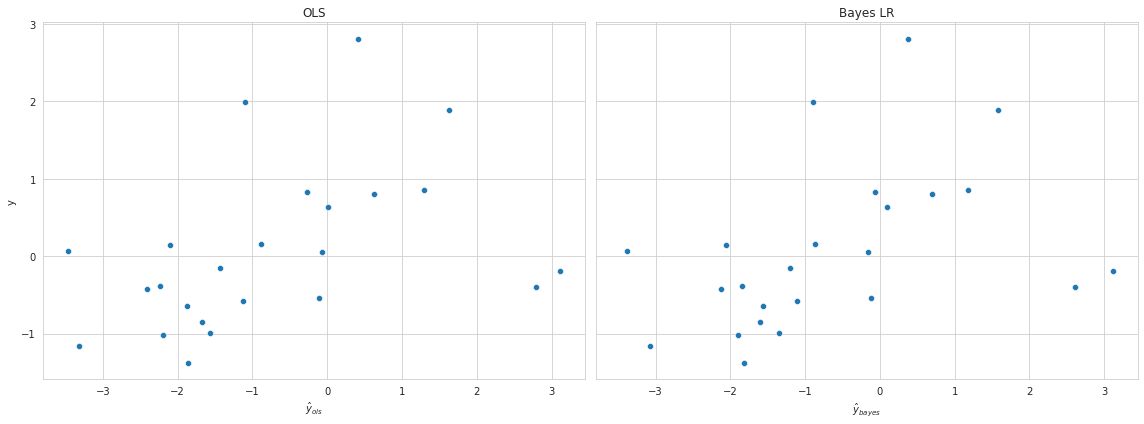

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)

y_hat_ols = ols.predict(X_test)
sns.scatterplot(x=y_hat_ols, y=y_test, ax=ax[0])
ax[0].set_title('OLS')
ax[0].set_xlabel('$\\hat{y}_{ols}$')

y_hat_bayes = pp['y'].mean(0)
sns.scatterplot(x=y_hat_bayes, y=y_test, ax=ax[1])
ax[1].set_title('Bayes LR')
ax[1].set_xlabel('$\\hat{y}_{bayes}$')

print(((y_test-y_hat_ols)**2).mean())
print(((y_test-y_hat_bayes)**2).mean())

fig.tight_layout()
fig.show()